# **Sentiment Analysis:**

The process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer’s attitude towards a particular topic, product, etc. is positive, negative, or neutral. In common ML words its just a classification problem.


# **Importing useful packages**

Lets first import all libraries. Please make sure that you have these libraries installed.

In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Data Preprocessing**


*   Reading the data
*   keeping only neccessary columns



In [2]:
data = pd.read_csv('data.csv')
data = data[['text','sentiment']]

In [3]:
data.head()

,text,sentiment
0,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
1,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
2,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
3,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
4,RT @warriorwoman91: I liked her and was happy ...,Negative


Class Split
Negative    8493
Positive    2236
Name: sentiment, dtype: int64


Text(0, 0.5, 'Count')

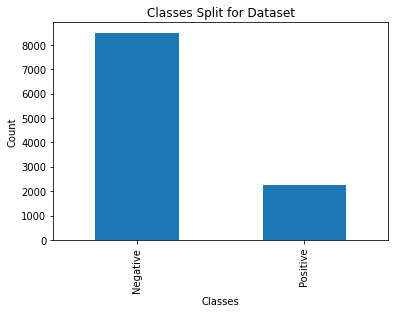

In [4]:
#Plotting Class Balance
print('Class Split')
print(data['sentiment'].value_counts())
data['sentiment'].value_counts().plot.bar(figsize=(6,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

**Lets pre-process the data so that we can use it to train the model**


*   Tokenize
*   Padding (to make all sequence of same lengths)
*   Converting sentiments into numerical data(One-hot form)
*   train test split




In [5]:
#declaring the maximum features for tokenizer
max_fatures = 2000
#creating word tokens
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
#padding the sequence of tokens
X = pad_sequences(X)
#converting sentiments to numerical form
Y = pd.get_dummies(data['sentiment']).values
#splitting training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)


(8583, 29) (8583, 2)


# **Defining model**

Next, I compose the LSTM Network. Note that embed_dim, lstm_out, batch_size, droupout_x variables are hyper parameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [6]:
#declaring embedding dimension
embed_dim = 128
#declaring LSTM units
lstm_out = 196
#define model
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#model summary
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 29, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


# **train and save first model**

Here we train the Network. We should run much more than 15 epoch, but I would have to wait forever (run it later), so it is 15 for now.

In [7]:
#training model
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
68/68 [==============================] - 32s 419ms/step - loss: 0.4935 - accuracy: 0.7910
Epoch 2/15
68/68 [==============================] - 28s 411ms/step - loss: 0.3393 - accuracy: 0.8511
Epoch 3/15
68/68 [==============================] - 28s 405ms/step - loss: 0.2874 - accuracy: 0.8814
Epoch 4/15
68/68 [==============================] - 27s 397ms/step - loss: 0.2681 - accuracy: 0.8914
Epoch 5/15
68/68 [==============================] - 27s 395ms/step - loss: 0.2449 - accuracy: 0.8951
Epoch 6/15
68/68 [==============================] - 29s 424ms/step - loss: 0.2346 - accuracy: 0.9032
Epoch 7/15
68/68 [==============================] - 27s 400ms/step - loss: 0.2184 - accuracy: 0.9087
Epoch 8/15
68/68 [==============================] - 27s 397ms/step - loss: 0.2023 - accuracy: 0.9136
Epoch 9/15
68/68 [==============================] - 27s 395ms/step - loss: 0.1924 - accuracy: 0.9198
Epoch 10/15
68/68 [==============================] - 28s 414ms/step - loss: 0.1810 - accura

In [8]:
#saving our first model
model.save('model.h5')

# **Evaluating the model**

In [9]:
#evaluating the model by sentiments value
predict_x = model.predict(X_test,batch_size = batch_size)
Y_pred = np.argmax(predict_x,axis=1)
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))

#print classification report
report = classification_report(df_test.true, df_test.pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1713
           1       0.59      0.58      0.59       433

    accuracy                           0.84      2146
   macro avg       0.74      0.74      0.74      2146
weighted avg       0.83      0.84      0.84      2146



It is clear that finding negative tweets (class 0) goes very well (recall 0.90) for the Network but deciding whether is positive (class 1) is not really (recall 0.58). My educated guess here is that the positive training set is dramatically smaller than the negative, hence the “bad” results for positive tweets.

# **Up-sample Minority Class**

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal. There are several heuristics for doing so, but the most common way is to simply re-sample with replacement.

It’s important that we separate test set before up-sampling because after up-sampling there will be multiple copies of same data point and if we do train test split after up-sampling the test set will not be completely unseen.

In [13]:
# Separate majority and minority classes
data_majority = data[data['sentiment'] == 'Negative']
data_minority = data[data['sentiment'] == 'Positive']

# will be used later in defining class weights
bias = data_minority.shape[0]/data_majority.shape[0]

# lets split train/test data first then 
train = pd.concat([data_majority.sample(frac=0.8,random_state=200),
         data_minority.sample(frac=0.8,random_state=200)])
test = pd.concat([data_majority.drop(data_majority.sample(frac=0.8,random_state=200).index),
        data_minority.drop(data_minority.sample(frac=0.8,random_state=200).index)])

train = shuffle(train)
test = shuffle(test)

#print sentiment classification in train and test data
print('positive data in training:',(train.sentiment == 'Positive').sum())
print('negative data in training:',(train.sentiment == 'Negative').sum())
print('positive data in test:',(test.sentiment == 'Positive').sum())
print('negative data in test:',(test.sentiment == 'Negative').sum())


positive data in training: 1789
negative data in training: 6794
positive data in test: 447
negative data in test: 1699


In [14]:
# Separate majority and minority classes in training data for up sampling 
data_majority = train[train['sentiment'] == 'Negative']
data_minority = train[train['sentiment'] == 'Positive']

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",data_upsampled.sentiment.value_counts(),sep = "")


majority class before upsample: (6794, 2)
minority class before upsample: (1789, 2)
After upsampling
Negative    6794
Positive    6794
Name: sentiment, dtype: int64


# **Repeating the Preprocessing steps after Up-sampling**

In [15]:
# training with whole data
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values) 

#tokenizing whole unsampled data
X_train = tokenizer.texts_to_sequences(data_upsampled['text'].values)
X_train = pad_sequences(X_train,maxlen=29)
Y_train = pd.get_dummies(data_upsampled['sentiment']).values
print('x_train shape:',X_train.shape)

#padding the whole upsampled data
X_test = tokenizer.texts_to_sequences(test['text'].values)
X_test = pad_sequences(X_test,maxlen=29)
Y_test = pd.get_dummies(test['sentiment']).values
print("x_test shape", X_test.shape)

# creating final LSTM model
embed_dim = 128
lstm_out = 192

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

#summary of Final model
print(model.summary())


x_train shape: (13588, 29)
x_test shape (2146, 29)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 29, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 29, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 192)               246528    
                                                                 
 dense_1 (Dense)             (None, 2)                 386       
                                                                 
Total params: 502,914
Trainable params: 502,914
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
#Training final model
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)


Epoch 1/15
107/107 [==============================] - 45s 368ms/step - loss: 0.5153 - accuracy: 0.7376
Epoch 2/15
107/107 [==============================] - 39s 368ms/step - loss: 0.3481 - accuracy: 0.8491
Epoch 3/15
107/107 [==============================] - 41s 381ms/step - loss: 0.3002 - accuracy: 0.8739
Epoch 4/15
107/107 [==============================] - 40s 369ms/step - loss: 0.2617 - accuracy: 0.8936
Epoch 5/15
107/107 [==============================] - 39s 362ms/step - loss: 0.2416 - accuracy: 0.9001
Epoch 6/15
107/107 [==============================] - 40s 372ms/step - loss: 0.2126 - accuracy: 0.9174
Epoch 7/15
107/107 [==============================] - 38s 359ms/step - loss: 0.1962 - accuracy: 0.9227
Epoch 8/15
107/107 [==============================] - 40s 370ms/step - loss: 0.1856 - accuracy: 0.9277
Epoch 9/15
107/107 [==============================] - 39s 360ms/step - loss: 0.1728 - accuracy: 0.9329
Epoch 10/15
107/107 [==============================] - 39s 362ms/step - l

In [17]:
#saving final model
model.save('final_model.h5')

# **Final Model Evaluation**

In [18]:
#Evaluating final model after upsampling the minority sentiment
predict_x = model.predict(X_test,batch_size = batch_size)
Y_pred = np.argmax(predict_x,axis=1)
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))

#print classification report
print(classification_report(df_test.true, df_test.pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1699
           1       0.55      0.65      0.59       447

    accuracy                           0.81      2146
   macro avg       0.72      0.75      0.74      2146
weighted avg       0.83      0.81      0.82      2146



After Upsampling of positive sentiment, it is clear that finding negative tweets (class 0) goes very well (recall 0.86) for the Network and positive (class 1) also increases slightly after upsampling(recall 0.65).

In [24]:
#Printing the accuracy of final model
print('Testing...')
score, acc = model.evaluate(X_test, Y_test, batch_size=128)

print('Validation Loss:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
17/17 [==============================] - 1s 69ms/step - loss: 0.6638 - accuracy: 0.8141
Validation Loss: 0.663760244846344
Test accuracy: 0.8140726685523987
Accuracy: 81.41%


# **Testing model on Two data points**

In [25]:
test_1 = ['You are bad.']
test_2 = ['You are good']
#vectorizing the tweet by the pre-fitted tokenizer instance
test_1 = tokenizer.texts_to_sequences(test_1)
#padding the tweet to have exactly the same shape as `embedding_2` input
test_1 = pad_sequences(test_1, maxlen=29, dtype='int32', value=0)

sentiment_1 = model.predict(test_1,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment_1) == 0):
    print("negative")
elif (np.argmax(sentiment_1) == 1):
    print("positive")

test_2 = tokenizer.texts_to_sequences(test_2)
#padding the tweet to have exactly the same shape as `embedding_2` input
test_2 = pad_sequences(test_2, maxlen=29, dtype='int32', value=0)

sentiment_2 = model.predict(test_2,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment_2) == 0):
    print("negative")
elif (np.argmax(sentiment_2) == 1):
    print("positive")

1/1 - 0s - 32ms/epoch - 32ms/step
negative
1/1 - 0s - 28ms/epoch - 28ms/step
positive


# **Conclusion** 
Thus from the output it is clearly observable that the model is successfully predicting two testing data points.


1.   **You are bad.** : negative
2.   **You are good.** : positive 

Thus due to upsampling the minority sentiment i.e. positive the number of duplicate positive sentiment increases in data and we successfully getting the desired output. Also the accuracy of model increase.

The **accuracy** of our final model is **81.41%**. 

**Recommendation**


I tried to get idea from "https://medium.com/analytics-vidhya/re-sampling-imbalanced-training-corpus-for-sentiment-analysis-c9dc97f9eae1" for resampling of the imbalanced data.

